## Westeros electrified - intoducing a LOW C02 cap

This notebook depicts the "strictest" C02 cap. This is realized by adding high emission taxes.

By Maja Heim

In [90]:
import pandas as pd
import ixmp
import message_ix

from message_ix.util import make_df

%matplotlib inline

In [91]:
mp = ixmp.Platform()

#### Analyzing the Emission Bound Scenario
At first I will be looking at the "emission bound" Westeros Scenario. Here we can see, that the emission prices are rising each year. This has to do with the general loss of value of money over time (Inflation)

In [92]:
model = "Westeros Electrified"
base = message_ix.Scenario(mp, model=model, scenario="emission_bound")
# Emissions in MtCO2
emissions = base.var("EMISS", {"node": "Westeros"})
emissions

,node,emission,type_tec,year,lvl,mrg
0,Westeros,CO2,all,700,350.569757,0.0
1,Westeros,CO2,all,710,651.988272,0.0
2,Westeros,CO2,all,720,797.441971,0.0


In [93]:
# Price in USD/tCO2
emission_prices = base.var("PRICE_EMISSION")
emission_prices

,node,type_emission,type_tec,year,lvl,mrg
0,Westeros,GHG,all,700,11.571898,0.0
1,Westeros,GHG,all,710,18.849403,0.0
2,Westeros,GHG,all,720,30.703691,0.0


#### Adding Emissions to the Baseline Scenario

In [94]:
base = message_ix.Scenario(mp, model="Westeros Electrified", scenario="baseline")
scen = base.clone(
    model,
    "emission_bound",
    "introducing emission taxes",
    keep_solution=False,
)
scen.check_out()
year_df = scen.vintage_and_active_years()
vintage_years, act_years = year_df["year_vtg"], year_df["year_act"]
model_horizon = scen.set("year")
country = "Westeros"

#Introducing Emissions:
# First we introduce the emission of CO2 and the emission category GHG
scen.add_set("emission", "CO2")
scen.add_cat("emission", "GHG", "CO2")

# Then we add new units to the model library (needed only once)
mp.add_unit("tCO2/kWa")     #tC02...tons of carbon dioxide
mp.add_unit("MtCO2")        #MtC02...mega tons of carbon dioxide

# Last we add CO2 emissions to the coal power plant
emission_factor = make_df(
        "emission_factor",
        node_loc=country,
        year_vtg=vintage_years,
        year_act=act_years,
        mode="standard",
        unit="tCO2/kWa",
        technology="coal_ppl",
        emission="CO2",
        value=7.4,
    )
scen.add_par("emission_factor", emission_factor)


#### Adding Emission Taxes
Inspired by the prices from above, the following were decided upon:

In [95]:
prices = [15, 25, 35]
emission_prices = pd.DataFrame(index=[700, 710, 720], data=prices, columns=["lvl"])

scen.add_set("type_year", [700, 710, 720])

# add units
mp.add_unit("USD/tCO2")

tax_emission = make_df(
    "tax_emission",
    node="Westeros",
    type_year=[700, 710, 720],
    type_tec="all",
    unit="USD/tCO2",
    type_emission="GHG",
    value=emission_prices.lvl,
)
scen.add_par("tax_emission", tax_emission)
scen.par("tax_emission")

,node,type_emission,type_tec,type_year,value,unit
0,Westeros,GHG,all,700,15.0,USD/tCO2
1,Westeros,GHG,all,710,25.0,USD/tCO2
2,Westeros,GHG,all,720,35.0,USD/tCO2


In [96]:
scen.commit(comment="introducing emission taxes")
scen.solve()
scen.var("EMISS", {"node": "Westeros"})
scen.var("OBJ")["lvl"]

363674.46875

#### Plotting Results

In [97]:
from message_ix.reporting import Reporter
from message_ix.util.tutorial import prepare_plots

# Scenario without share constraint
base_rep = Reporter.from_scenario(base)
prepare_plots(base_rep)

# Scenario with share constraint
rep = Reporter.from_scenario(scen)
prepare_plots(rep)

### Activity
--> The amount of energy that is generated in each time period from the different potential sources.

We can see that we have created a very low bound on the emissions with the chosen tax prices. The amount of taxes having to be paid are so high, that it has become cheaper to produce energy solely from wind. This can be seen in the two graphs below, depicting the activity. By 720, energy is being created only through renewable (wind) sources.

<Axes: title={'center': 'Westeros Energy System Activity'}, xlabel='Year', ylabel='GWa'>

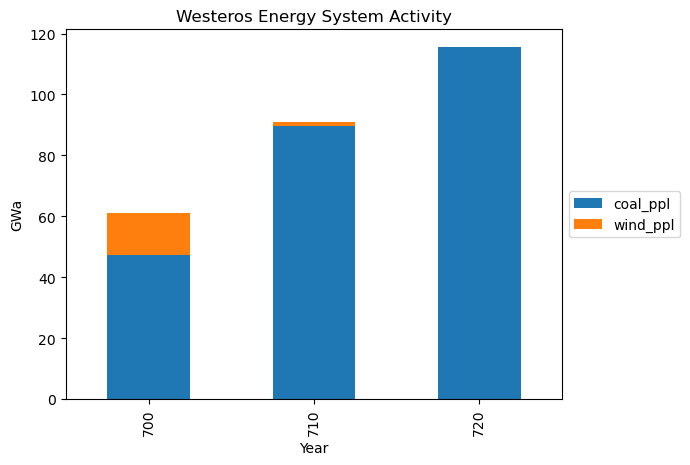

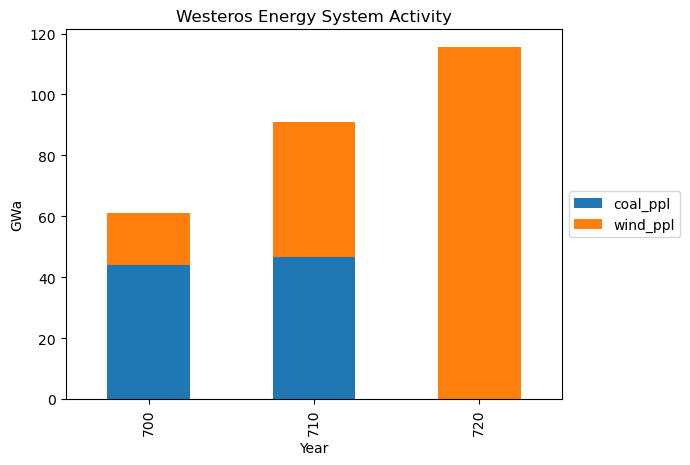

In [98]:
plants = ["coal_ppl", "wind_ppl"]
base_rep.set_filters(t=plants)
base_rep.get("plot activity")

rep.set_filters(t=plants)
rep.get("plot activity")

### Capacity
--> The amount of capacity of each plant that is installed

The capacity reflects the results from above. The amount of wind power plants being installed increases each year until it reaches 100% in 720.

<Axes: title={'center': 'Westeros Energy System Capacity'}, xlabel='Year', ylabel='GW'>

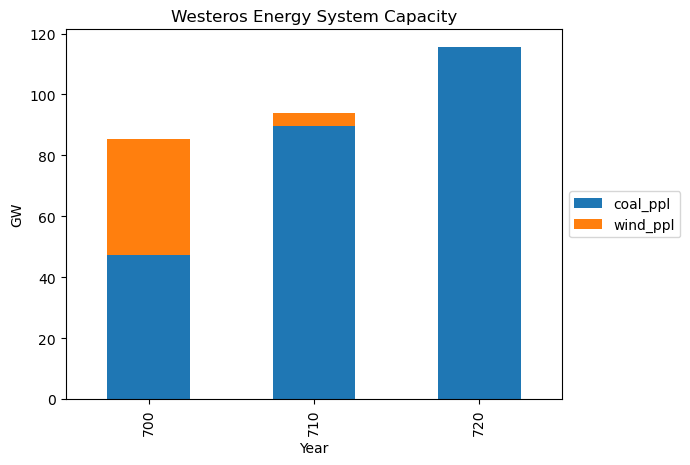

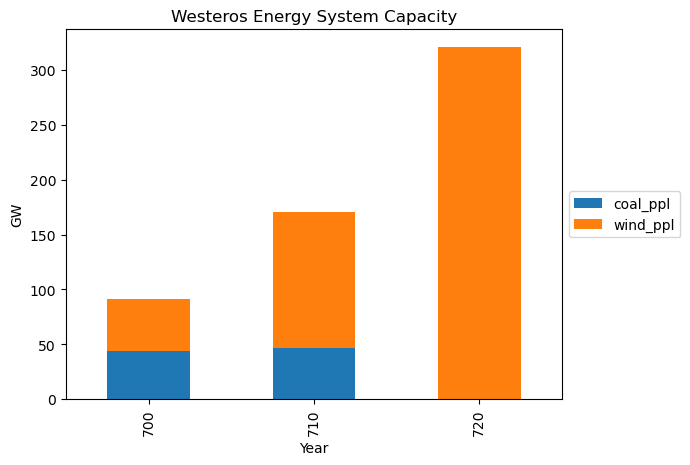

In [99]:
base_rep.get("plot capacity")
rep.get("plot capacity")

### Electricity Price
--> The price of electricity

The electricity prices over the course of time stays relatively stable, especially in the last two decades. Once wind power plants have been built and invested into, the electricity price does not skyrocket. Yes, all in all, electricity generated from renewables is still more expensive, but it does level out over time. The price is the highest in the beginning because of the investments that have to be made, because the capacity has to increase. With the introduced taxes, it becomes cheaper to generate electricity through wind, resulting in the large capacity increase of wind.

<Axes: title={'center': 'Westeros Energy System Prices'}, xlabel='Year', ylabel='¢/kW·h'>

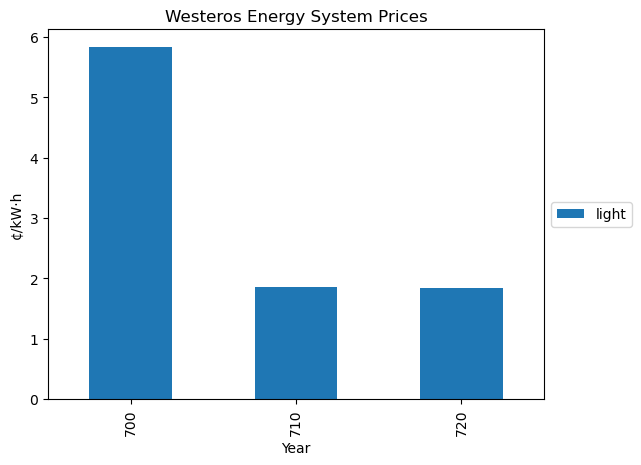

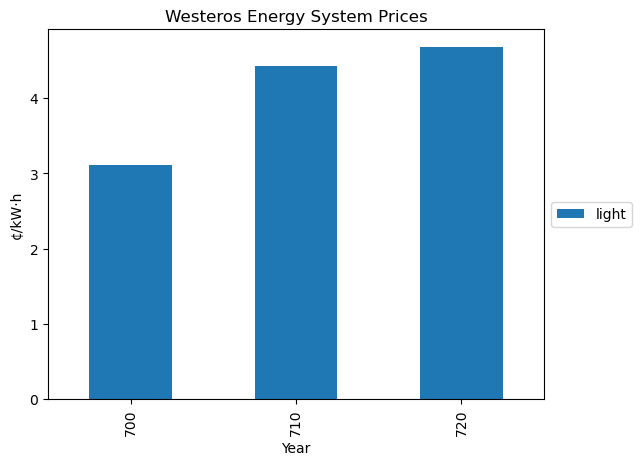

In [100]:
filters = dict(t=None, c=["light"])
base_rep.set_filters(**filters)
base_rep.get("plot prices")

rep.set_filters(**filters)
rep.get("plot prices")

## Close the connection to the database

In [101]:
mp.close_db()

# Overall Conclusion

All in all, we can see the adding a C02 cap obviously reduces the amount of emissions released. There are many different ways on how emissions can be reduced. The first notebook (high bound) solely analyzed what effect a bound would have on the system. The other two notebooks (medium and low bound) introduced two different ways on how a cap on emissions can be achieved through exterior constraints.

In the medium bound scenario, the energy mix requirement is only reached in 720. This is because of the diffusion rate of wind. Because the capacity has to be increased over time, it takes a while for the requirement to be met.

The low bound scenario is able to reach 0% emissions by the year 720, due to the high emission taxes. This is a very effective way of reducing emissions. It does result in higher electricity prices, but fot the fact that zero emissions is achieved, the price isn't that high.